In [1]:
# Monte-Carlo playoff odds
# Generate my own playoff odds

# For now, I'm focusing on the mechanics of the simulation, and less so on the inputs (e.g., the projected team quality)
# So I'm using 538's win probabilities for each game, rather than computing my own

# I'm also using 538's results/schedule data, because it is so easy to use

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
# Read in the 538 dataset, which has a row for each game in the current season (played or unplayed)
gms = pd.read_csv('https://projects.fivethirtyeight.com/mlb-api/mlb_elo_latest.csv')
#gms = pd.read_csv('../data/538/mlb-elo/mlb_elo_latest.csv')
gms

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2022-10-05,2022,0,NaN,LAD,COL,1595.227284,1473.590584,0.698118,0.301882,...,NaN,NaN,NaN,NaN,0.716672,0.283328,NaN,NaN,NaN,NaN
1,2022-10-05,2022,0,NaN,SEA,DET,1526.471022,1454.311638,0.634956,0.365044,...,NaN,NaN,NaN,NaN,0.621276,0.378724,NaN,NaN,NaN,NaN
2,2022-10-05,2022,0,NaN,SDP,SFG,1509.061740,1524.576347,0.512209,0.487791,...,NaN,NaN,NaN,NaN,0.562764,0.437236,NaN,NaN,NaN,NaN
3,2022-10-05,2022,0,NaN,NYM,WSN,1537.666592,1441.174433,0.666769,0.333231,...,NaN,NaN,NaN,NaN,0.677569,0.322431,NaN,NaN,NaN,NaN
4,2022-10-05,2022,0,NaN,MIL,ARI,1519.040067,1473.137932,0.599262,0.400738,...,NaN,NaN,NaN,NaN,0.621928,0.378072,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2022-04-07,2022,0,NaN,ATL,CIN,1555.630840,1501.967218,0.609942,0.390058,...,58.198554,53.297336,18.664382,15.512738,0.620108,0.379892,1552.570297,1501.193092,3.0,6.0
2426,2022-04-07,2022,0,NaN,WSN,NYM,1476.319846,1495.202033,0.507365,0.492635,...,46.506602,48.182760,-10.890192,-33.183129,0.495889,0.504111,1467.302390,1522.210391,1.0,5.0
2427,2022-04-07,2022,0,NaN,STL,PIT,1524.880454,1456.114951,0.630416,0.369584,...,57.273136,46.669517,27.921385,2.182563,0.650312,0.349688,1503.439418,1444.031029,9.0,0.0
2428,2022-04-07,2022,0,NaN,KCR,CLE,1480.923133,1501.256999,0.505276,0.494724,...,50.288294,59.572636,7.862364,30.139987,0.476089,0.523911,1473.144618,1491.474766,3.0,1.0


In [3]:
gms.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'rating1_pre', 'rating2_pre', 'pitcher1', 'pitcher2', 'pitcher1_rgs',
       'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj', 'rating_prob1',
       'rating_prob2', 'rating1_post', 'rating2_post', 'score1', 'score2'],
      dtype='object')

In [4]:
# Split out the games that have been played vs those remaining
played = gms.dropna(subset=['score1']) # games that have a score
remain = gms.loc[gms.index.difference(played.index)] # all other games
played.shape, remain.shape

((1462, 26), (968, 26))

# Define some functions that will be used in the simulation

In [5]:
def compute_standings(gms_played):
    margins = gms_played['score1']-gms_played['score2']
    winners = pd.Series(np.where(margins>0, gms_played['team1'], gms_played['team2']))
    losers  = pd.Series(np.where(margins<0, gms_played['team1'], gms_played['team2']))
    standings = pd.concat([winners.value_counts().rename('W'), losers.value_counts().rename('L')], axis=1)
    return standings

compute_standings(played)

,W,L
NYY,66,32
HOU,64,34
LAD,64,32
NYM,60,37
ATL,59,40
SDP,55,44
TOR,54,43
MIL,54,44
SEA,53,45
MIN,52,45


In [6]:
random_inputs = {}

NUM_RANDOMS_PER_ITERATION = 1200
def get_randoms(iteration: int) -> pd.Series:
    if iteration not in random_inputs:
        # Generate a random number for each game
        randoms = pd.Series(np.random.rand(NUM_RANDOMS_PER_ITERATION))
        random_inputs[iteration] = randoms
    
    return random_inputs[iteration]
    
get_randoms(0)

0       0.799105
1       0.732344
2       0.767044
3       0.973204
4       0.576507
          ...   
1195    0.812418
1196    0.571096
1197    0.994348
1198    0.406717
1199    0.345428
Length: 1200, dtype: float64

In [7]:
# This is the source data for the mapping of teams to divisions/leagues
div_text = '''
NLW: ARI COL LAD SDP SFG
NLE: ATL FLA NYM PHI WSN
ALW: SEA ANA HOU OAK TEX
ALE: TBD TOR BAL NYY BOS
ALC: MIN CHW CLE KCR DET
NLC: STL MIL CHC PIT CIN
'''

divs = {line.split(': ')[0]: line.split(': ')[1].split(' ') for line in div_text.strip().split('\n')}
teams = pd.DataFrame(pd.concat([pd.Series({team: div for team in teams}) for (div, teams) in divs.items()]).rename('div'))
teams['lg'] = teams['div'].str[0]
teams

,div,lg
ARI,NLW,N
COL,NLW,N
LAD,NLW,N
SDP,NLW,N
SFG,NLW,N
ATL,NLE,N
FLA,NLE,N
NYM,NLE,N
PHI,NLE,N
WSN,NLE,N


In [8]:

def sim_rem_games(remain: pd.DataFrame, randoms: pd.Series):
    # Figure out the winners and losers
    rands = randoms[0:len(remain)]
    rands.index = remain.index
    winners = pd.Series(np.where(rands<remain['rating_prob1'], remain['team1'], remain['team2']))
    losers = pd.Series(np.where(rands>remain['rating_prob1'], remain['team1'], remain['team2']))

    # Compute and return the standings
    standings = pd.concat([winners.value_counts().rename('W'), losers.value_counts().rename('L')], axis=1)
    for col in standings.columns: # convert to int
        standings[col] = standings[col].fillna(0).astype(int)
    return standings

rand0 = get_randoms(0)
sim_rem_games(remain, rand0)

,W,L
CHW,42,23
HOU,41,23
LAD,40,26
MIL,38,26
NYY,38,26
CLE,37,29
TBD,37,28
TOR,35,30
PHI,35,30
SDP,34,29


In [9]:
rand0 = get_randoms(0)
type(rand0)


pandas.core.series.Series

In [10]:
cur_standings = compute_standings(played)
rem_standings = sim_rem_games(remain, rand0)
full_standings = cur_standings+rem_standings
full_standings

,W,L
ANA,75,87
ARI,78,84
ATL,90,72
BAL,73,89
BOS,83,79
CHC,72,90
CHW,91,71
CIN,67,95
CLE,86,76
COL,69,93


In [11]:
# find playoff teams
def add_playoff_seeds(standings, randoms):
    standings['wpct'] = standings['W'] / (standings['W'] + standings['L'])

    # Merge in the div/lg data
    standings['div'] = teams['div']
    standings['lg'] = teams['lg']

    # Rather than model out all the tie-breakers, I'm assuming that they are all random (not exactly true, but close enough),
    # and so I'm just generating a random number for each team, and we break ties by comparing that random num for each of the tied teams.
    # This is *so* much simpler and faster than modeling all the different scenarios.
    # It might be worth modeling them out with 1-2 days left in the season, but for most of the season, I way prefer using the random num to break ties
    rands = randoms[0:len(standings)]
    rands.index = standings.index
    standings['rand'] = rands

    # Now sort, and break ties using the rand
    sorted = standings.sort_values(by=['wpct', 'rand'], ascending=False)

    # div_rank is nice to have, but somewhat expensive to compute
    #standings['div_rank'] = sorted.groupby('div').cumcount()+1
    #standings['div_win'] = standings['div_rank'] == 1

    # Set div_win False as default, then set it True for div winners
    standings['div_win'] = False
    standings.loc[sorted.groupby('div').head(1).index, 'div_win'] = True
    standings['lg_rank'] = standings.sort_values(by=['div_win', 'wpct', 'rand'], ascending=False).groupby('lg').cumcount()+1
    return standings.sort_values(['lg', 'lg_rank'])

     

add_playoff_seeds(full_standings, rand0)

,W,L,wpct,div,lg,rand,div_win,lg_rank
HOU,105,57,0.648148,ALW,A,0.024248,True,1
NYY,104,58,0.641975,ALE,A,0.919595,True,2
CHW,91,71,0.561728,ALC,A,0.203911,True,3
TOR,89,73,0.549383,ALE,A,0.932898,False,4
TBD,89,73,0.549383,ALE,A,0.233582,False,5
CLE,86,76,0.530864,ALC,A,0.208663,False,6
SEA,83,79,0.512346,ALW,A,0.639152,False,7
BOS,83,79,0.512346,ALE,A,0.576507,False,8
MIN,81,81,0.500000,ALC,A,0.400814,False,9
TEX,77,85,0.475309,ALW,A,0.162320,False,10


In [12]:
%%prun -s cumulative # This runs the code profiler, which creates data I can use to find opportunities for me to speed up the code

[add_playoff_seeds(full_standings, rand0) for _ in range(1000)]
None # This is to suppress printing the output, which is 1000 lines of the same list of teams

         11681933 function calls (11549933 primitive calls) in 5.735 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.735    5.735 {built-in method builtins.exec}
        1    0.003    0.003    5.735    5.735 <string>:3(<module>)
        1    0.004    0.004    5.731    5.731 <string>:3(<listcomp>)
     1000    0.027    0.000    5.727    0.006 <ipython-input-11-489943b25d01>:2(add_playoff_seeds)
     3000    0.005    0.000    2.484    0.001 _decorators.py:302(wrapper)
     3000    0.025    0.000    2.476    0.001 frame.py:6269(sort_values)
     3000    0.093    0.000    1.750    0.001 sorting.py:285(lexsort_indexer)
     7000    0.049    0.000    1.276    0.000 categorical.py:365(__init__)
    16000    0.042    0.000    1.217    0.000 frame.py:3463(__getitem__)
     1000    0.005    0.000    1.111    0.001 groupby.py:3040(cumcount)
51000/35000    0.028    0.000    0.865    0.000 groupby.py:9

In [13]:
def finish_one_season(incoming_standings, remain, randoms):
    rem_standings = sim_rem_games(remain, randoms)
    full_standings = incoming_standings+rem_standings
    full_standings = add_playoff_seeds(full_standings, randoms)
    return full_standings

finish_one_season(cur_standings, remain, rand0)

,W,L,wpct,div,lg,rand,div_win,lg_rank
HOU,105,57,0.648148,ALW,A,0.024248,True,1
NYY,104,58,0.641975,ALE,A,0.919595,True,2
CHW,91,71,0.561728,ALC,A,0.203911,True,3
TOR,89,73,0.549383,ALE,A,0.932898,False,4
TBD,89,73,0.549383,ALE,A,0.233582,False,5
CLE,86,76,0.530864,ALC,A,0.208663,False,6
SEA,83,79,0.512346,ALW,A,0.639152,False,7
BOS,83,79,0.512346,ALE,A,0.576507,False,8
MIN,81,81,0.500000,ALC,A,0.400814,False,9
TEX,77,85,0.475309,ALW,A,0.162320,False,10


In [14]:
def sim_1_season(incoming_standings, remain, i):
    randoms = get_randoms(i)
    standings = finish_one_season(incoming_standings, remain, randoms)
    standings['iter'] = i
    standings = standings.reset_index().rename(columns={'index': 'team'}).set_index(['team', 'iter'])
    return standings

def sim_n_seasons(incoming_standings, remain, n):
    return pd.concat([sim_1_season(incoming_standings, remain, i) for i in range(n)])

sim_results = sim_n_seasons(cur_standings, remain, 10)
sim_results

,,W,L,wpct,div,lg,rand,div_win,lg_rank
team,iter,,,,,,,,
HOU,0,105,57,0.648148,ALW,A,0.024248,True,1
NYY,0,104,58,0.641975,ALE,A,0.919595,True,2
CHW,0,91,71,0.561728,ALC,A,0.203911,True,3
TOR,0,89,73,0.549383,ALE,A,0.932898,False,4
TBD,0,89,73,0.549383,ALE,A,0.233582,False,5
...,...,...,...,...,...,...,...,...,...
COL,9,71,91,0.438272,NLW,N,0.051515,False,11
CIN,9,68,94,0.419753,NLC,N,0.522775,False,12
PIT,9,66,96,0.407407,NLC,N,0.694495,False,13


In [15]:
# Count the number of div/wc/playoff appearances by team from a set of results

# Championship weights by seed position
weights = {i: 1/16 for i in range(1,7)}
weights[1] = 1/8
weights[2] = 1/8

def summarize_sim_results(df_results):
    counts = df_results.query('lg_rank <= 6').reset_index()[['team', 'lg_rank']].value_counts().unstack()
    mean_wins = df_results.groupby('team')['W'].mean().rename('mean_wins')
    summary = pd.merge(left=mean_wins, right=counts, on='team', how='left')
    for col in counts.columns:
        summary[col] = summary[col].fillna(0).astype(int)    

    summary['div_wins'] = summary[range(1, 4)].sum(axis=1)
    summary['playoffs'] = summary[range(1, 7)].sum(axis=1)
    summary['champ_shares'] = (summary[range(1,7)] * np.array(weights)).sum(axis=1)
    return summary

summarize_sim_results(sim_results)

,mean_wins,1,2,3,4,5,6,div_wins,playoffs,champ_shares
team,,,,,,,,,,
ANA,72.3,0,0,0,0,0,0,0,0,0.0000
ARI,72.8,0,0,0,0,0,0,0,0,0.0000
ATL,96.8,1,5,0,3,1,0,6,10,1.0000
BAL,75.4,0,0,0,0,0,1,0,1,0.0625
BOS,82.5,0,0,0,1,2,0,0,3,0.1875
CHC,70.6,0,0,0,0,0,0,0,0,0.0000
CHW,84.1,0,0,3,0,0,0,3,3,0.1875
CIN,69.3,0,0,0,0,0,0,0,0,0.0000
CLE,81.3,0,0,1,0,0,1,1,2,0.1250


In [16]:
#%%prun -s cumulative # This runs the code profiler, which creates data I can use to find opportunities for me to speed up the code

sim_results = sim_n_seasons(cur_standings, remain, 10*1000)
summarize_sim_results(sim_results)

,mean_wins,1,2,3,4,5,6,div_wins,playoffs,champ_shares
team,,,,,,,,,,
ANA,73.0918,0,0,0,0,11,23,0,34,2.1250
ARI,71.6189,0,0,0,0,3,17,0,20,1.2500
ATL,95.2565,238,3333,130,4805,1178,243,3701,9927,843.6250
BAL,77.5889,0,0,0,24,122,283,0,429,26.8125
BOS,81.1052,0,0,0,148,612,1053,0,1813,113.3125
CHC,70.0784,0,0,2,0,0,5,2,7,0.4375
CHW,85.8928,0,18,4493,133,659,1153,4511,6456,404.6250
CIN,68.6011,0,0,1,0,0,0,1,1,0.0625
CLE,82.4048,0,3,1542,77,438,957,1545,3017,188.7500


In [17]:
sim_results.groupby('iter')['W'].max().median()

108.0

In [104]:
summary = summarize_sim_results(sim_results)
print(summary.sort_values('champ_shares', ascending=False).to_string())

      mean_wins     1     2     3     4     5     6  div_wins  playoffs  champ_shares
team                                                                                 
LAD    105.7854  9085   873    14    19     8     1      9972     10000     1247.3750
HOU    102.6432  3498  6442    21    21    14     2      9961      9998     1246.1250
NYY    104.8385  6485  3417     5    85     7     1      9907     10000     1243.8750
NYM     97.2665   657  5425   156  3074   579    95      6238      9986     1004.2500
ATL     95.2565   238  3333   130  4805  1178   243      3701      9927      843.6250
TOR     90.9987    13    75     1  6514  1927   848        89      9378      591.6250
MIL     89.0575     9   268  7180    42   389   925      7457      8813      568.1250
SDP     89.0260    10    17     1  1590  5104  1896        28      8618      540.3125
SEA     86.8978     4    32     3  1694  3450  2156        39      7339      460.9375
CHW     85.8928     0    18  4493   133   659  1153   

In [19]:
# How many games does each team win in each seeding?
sim_results.query('lg_rank <= 6').groupby(['team', 'lg_rank'])['W'].mean().unstack()

lg_rank,1,2,3,4,5,6
team,,,,,,
ANA,NaN,NaN,NaN,NaN,85.727273,83.565217
ARI,NaN,NaN,NaN,NaN,85.333333,82.235294
ATL,101.920168,98.195320,94.346154,94.451197,91.037351,88.135802
BAL,NaN,NaN,NaN,88.166667,86.319672,84.632509
BOS,NaN,NaN,NaN,89.743243,87.289216,85.426401
CHC,NaN,NaN,85.500000,NaN,NaN,81.400000
CHW,NaN,94.166667,88.652348,89.015038,87.132018,85.519514
CIN,NaN,NaN,83.000000,NaN,NaN,NaN
CLE,NaN,95.000000,87.534371,88.454545,86.632420,85.135841


In [105]:
# How many wins do teams have in division-winning seasons?
sim_results.query('div_win').groupby('team')['W'].mean()

team
ATL     98.299649
CHC     85.500000
CHW     88.674352
CIN     83.000000
CLE     87.548867
HOU    102.679851
LAD    105.811071
MIL     90.322382
MIN     88.533976
NYM     99.130811
NYY    104.914707
PHI     93.934426
SDP     97.928571
SEA     95.230769
STL     88.809843
TBD     95.250000
TOR     98.752809
Name: W, dtype: float64

In [106]:
# How often do teams win the division when they win 95 games?
finishes = sim_results.query('W>=95').groupby('team').agg(num_seasons=('div_win', len), div_wins=('div_win', sum))
finishes['pct_win'] = finishes['div_wins']/finishes['num_seasons']
finishes


,num_seasons,div_wins,pct_win
team,,,
ATL,5783,3352,0.579630
CHW,136,136,1.000000
CLE,13,13,1.000000
HOU,9781,9764,0.998262
LAD,9975,9952,0.997694
MIL,826,826,1.000000
MIN,95,95,1.000000
NYM,7568,5799,0.766253
NYY,9958,9885,0.992669


In [22]:
pads95 = sim_results.query('team=="SDP" and W>=95').reset_index()['iter']
sim_results.query('iter in @pads95 and div=="NLW"').groupby('team')['W'].mean()

team
ARI     70.911343
COL     69.293351
LAD    104.349413
SDP     96.235984
SFG     80.357236
Name: W, dtype: float64

In [23]:
remain.tail(10)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
958,2022-07-27,2022,0,NaN,CIN,FLA,1470.924453,1479.223605,0.522580,0.477420,...,58.942305,49.964907,40.701899,-15.769602,0.591723,0.408277,NaN,NaN,NaN,NaN
959,2022-07-27,2022,0,NaN,SEA,TEX,1526.471022,1477.022146,0.604154,0.395846,...,49.477209,56.231419,-7.613077,25.722836,0.544018,0.455982,NaN,NaN,NaN,NaN
960,2022-07-27,2022,0,NaN,ARI,SFG,1473.137932,1524.576347,0.460595,0.539405,...,55.432549,57.600597,22.122193,19.144140,0.478796,0.521204,NaN,NaN,NaN,NaN
961,2022-07-27,2022,0,NaN,OAK,HOU,1466.296689,1568.647821,0.389117,0.610883,...,53.154179,55.644334,16.525329,2.705055,0.380069,0.619931,NaN,NaN,NaN,NaN
962,2022-07-27,2022,0,NaN,LAD,WSN,1595.227284,1441.174433,0.735937,0.264063,...,52.045648,43.804003,-14.740036,-11.461262,0.733926,0.266074,NaN,NaN,NaN,NaN
963,2022-07-27,2022,0,NaN,COL,CHW,1473.590584,1515.379824,0.474422,0.525578,...,51.213899,51.471608,-0.452031,-2.252013,0.444101,0.555899,NaN,NaN,NaN,NaN
964,2022-07-27,2022,0,NaN,MIL,MIN,1519.040067,1511.261353,0.545606,0.454394,...,63.383118,51.002092,44.457817,0.226614,0.617005,0.382995,NaN,NaN,NaN,NaN
965,2022-07-27,2022,0,NaN,KCR,ANA,1455.791428,1476.662065,0.504503,0.495497,...,49.298263,46.549951,3.889983,-24.797138,0.515180,0.484820,NaN,NaN,NaN,NaN
966,2022-07-27,2022,0,NaN,DET,SDP,1454.311638,1509.061740,0.455862,0.544138,...,52.557986,56.778749,15.742231,19.224651,0.427220,0.572780,NaN,NaN,NaN,NaN
967,2022-07-27,2022,0,NaN,PHI,ATL,1518.096196,1557.758355,0.477476,0.522524,...,50.765463,56.256278,-20.279404,9.412175,0.446445,0.553555,NaN,NaN,NaN,NaN


In [24]:

def sim_one_way(game_id, prob, num_iterations):
    orig_prob = remain.loc[game_id, 'rating_prob1']
    remain.loc[game_id, 'rating_prob1'] = prob
    sim_results = sim_n_seasons(cur_standings, remain, num_iterations)
    remain.loc[game_id, 'rating_prob1'] = orig_prob
    results = summarize_sim_results(sim_results)
    wp1 = results['champ_shares'].rename(f'{prob}')
    return wp1

def sim_both_ways(game_id, num_iterations):
    results = pd.concat([sim_one_way(game_id, prob, num_iterations) for prob in [0, 1]], axis=1)

    team1 = remain.loc[game_id, 'team1']
    diff = (results['1'] - results['0']).rename(game_id)
    return diff


sim_both_ways(966, 100)



team
ANA    0.0000
ARI    0.0000
ATL    0.0000
BAL    0.0000
BOS    0.0000
CHC    0.0000
CHW    0.0000
CIN    0.0000
CLE    0.0000
COL    0.0000
DET    0.0000
FLA    0.0000
HOU    0.0000
KCR    0.0000
LAD    0.0000
MIL    0.0000
MIN    0.0000
NYM    0.0000
NYY    0.0000
OAK    0.0000
PHI    0.1250
PIT    0.0000
SDP   -0.1875
SEA    0.0000
SFG    0.0000
STL    0.0625
TBD    0.0000
TEX    0.0000
TOR    0.0000
WSN    0.0000
Name: 966, dtype: float64

In [25]:
len(random_inputs)

10000

In [26]:
remain.tail(15)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
953,2022-07-28,2022,0,NaN,BAL,TBD,1490.505633,1538.121937,0.466066,0.533934,...,48.988097,NaN,-0.348478,NaN,0.452538,0.547462,NaN,NaN,NaN,NaN
954,2022-07-27,2022,0,NaN,BOS,CLE,1508.680251,1506.052015,0.538246,0.461754,...,53.598039,52.283086,8.686649,-2.355513,0.576456,0.423544,NaN,NaN,NaN,NaN
955,2022-07-27,2022,0,NaN,TOR,STL,1544.775071,1523.178073,0.565245,0.434755,...,55.596122,55.220427,13.191182,20.842225,0.580799,0.419201,NaN,NaN,NaN,NaN
956,2022-07-27,2022,0,NaN,BAL,TBD,1490.505633,1538.121937,0.466066,0.533934,...,53.728152,53.913618,21.929779,3.120031,0.483929,0.516071,NaN,NaN,NaN,NaN
957,2022-07-27,2022,0,NaN,NYM,NYY,1537.666592,1582.669429,0.469811,0.530189,...,63.023517,51.251827,39.337151,-21.955405,0.567917,0.432083,NaN,NaN,NaN,NaN
958,2022-07-27,2022,0,NaN,CIN,FLA,1470.924453,1479.223605,0.522580,0.477420,...,58.942305,49.964907,40.701899,-15.769602,0.591723,0.408277,NaN,NaN,NaN,NaN
959,2022-07-27,2022,0,NaN,SEA,TEX,1526.471022,1477.022146,0.604154,0.395846,...,49.477209,56.231419,-7.613077,25.722836,0.544018,0.455982,NaN,NaN,NaN,NaN
960,2022-07-27,2022,0,NaN,ARI,SFG,1473.137932,1524.576347,0.460595,0.539405,...,55.432549,57.600597,22.122193,19.144140,0.478796,0.521204,NaN,NaN,NaN,NaN
961,2022-07-27,2022,0,NaN,OAK,HOU,1466.296689,1568.647821,0.389117,0.610883,...,53.154179,55.644334,16.525329,2.705055,0.380069,0.619931,NaN,NaN,NaN,NaN
962,2022-07-27,2022,0,NaN,LAD,WSN,1595.227284,1441.174433,0.735937,0.264063,...,52.045648,43.804003,-14.740036,-11.461262,0.733926,0.266074,NaN,NaN,NaN,NaN


In [27]:
next_dt = remain['date'].min()
game_ids = remain.query('date == @next_dt').index.values
game_ids

array([954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966,
       967])

In [98]:
results = pd.DataFrame()
for i in range(6):
    num_iterations = 10 ** i
    print(f'Starting {num_iterations} iterations')
    results = pd.concat([sim_both_ways(game_id, num_iterations) for game_id in game_ids], axis=1)
    print(results)

Starting 1 iterations
      954  955  956  957  958  959  960  961  962  963  964  965  966  967
team                                                                      
ANA   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
ARI   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
ATL   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
BAL   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
BOS   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CHC   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CHW   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CIN   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CLE   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
COL   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
DET   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
FLA

In [99]:
game_descs = remain.apply(lambda x: f'{x.team2}\n@{x.team1}', axis=1)
game_descs.to_dict()

{0: 'COL\n@LAD',
 1: 'DET\n@SEA',
 2: 'SFG\n@SDP',
 3: 'WSN\n@NYM',
 4: 'ARI\n@MIL',
 5: 'PHI\n@HOU',
 6: 'ATL\n@FLA',
 7: 'KCR\n@CLE',
 8: 'CHC\n@CIN',
 9: 'MIN\n@CHW',
 10: 'TBD\n@BOS',
 11: 'NYY\n@TEX',
 12: 'STL\n@PIT',
 13: 'TOR\n@BAL',
 14: 'ANA\n@OAK',
 15: 'COL\n@LAD',
 16: 'DET\n@SEA',
 17: 'SFG\n@SDP',
 18: 'ANA\n@OAK',
 19: 'PHI\n@HOU',
 20: 'MIN\n@CHW',
 21: 'NYY\n@TEX',
 22: 'ARI\n@MIL',
 23: 'WSN\n@NYM',
 24: 'TBD\n@BOS',
 25: 'TOR\n@BAL',
 26: 'ATL\n@FLA',
 27: 'CHC\n@CIN',
 28: 'STL\n@PIT',
 29: 'DET\n@SEA',
 30: 'KCR\n@CLE',
 31: 'NYY\n@TEX',
 32: 'COL\n@LAD',
 33: 'DET\n@SEA',
 34: 'SFG\n@SDP',
 35: 'ANA\n@OAK',
 36: 'PHI\n@HOU',
 37: 'MIN\n@CHW',
 38: 'ARI\n@MIL',
 39: 'WSN\n@NYM',
 40: 'TBD\n@BOS',
 41: 'NYY\n@TEX',
 42: 'TOR\n@BAL',
 43: 'ATL\n@FLA',
 44: 'CHC\n@CIN',
 45: 'STL\n@PIT',
 46: 'KCR\n@CLE',
 47: 'OAK\n@SEA',
 48: 'CHW\n@SDP',
 49: 'COL\n@LAD',
 50: 'TEX\n@ANA',
 51: 'ARI\n@SFG',
 52: 'CIN\n@CHC',
 53: 'PIT\n@STL',
 54: 'FLA\n@MIL',
 55: 'TBD\n@HOU',
 5

In [100]:
for_graphing = results/(num_iterations/100)
for_graphing = for_graphing.rename(columns=game_descs.to_dict())
teamwise_leverage = for_graphing.abs().sum(axis=1).sort_values(ascending=False)
teamwise_leverage


team
PHI    1.082562
STL    1.011562
CLE    0.908500
TBD    0.900062
MIN    0.887375
CHW    0.876187
ATL    0.845813
NYM    0.824000
SEA    0.761813
BOS    0.638750
MIL    0.629125
SFG    0.626187
SDP    0.580750
TOR    0.332375
BAL    0.211250
FLA    0.094750
NYY    0.056688
HOU    0.040188
LAD    0.031625
ANA    0.023000
TEX    0.018313
ARI    0.011250
CHC    0.002750
COL    0.002625
CIN    0.001813
KCR    0.000250
PIT    0.000063
OAK    0.000000
DET    0.000000
WSN    0.000000
dtype: float64

<AxesSubplot:ylabel='team'>

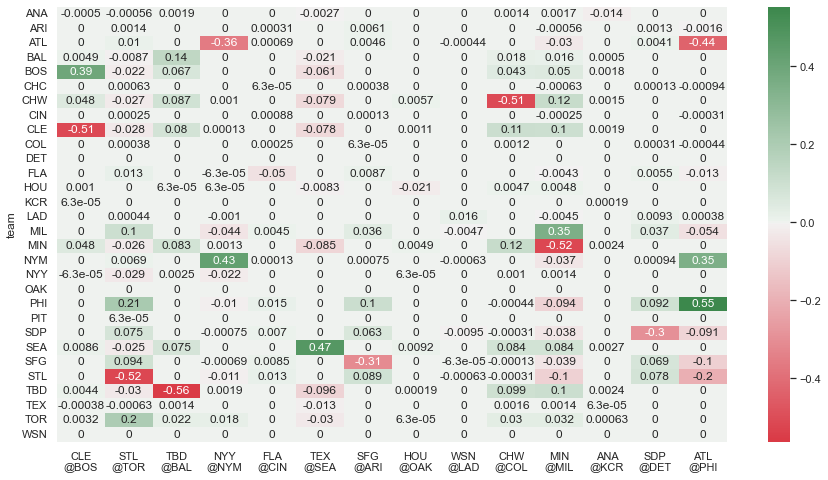

In [101]:
sns.set(rc = {'figure.figsize':(15,8)})
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(for_graphing, cmap=cmap, annot=True, center=0)

In [102]:
(abs(results)).sum(axis=0).sort_values()

965      28.250
962      32.000
961      42.375
958      99.000
966     593.375
960     625.375
957     900.625
959     945.125
963    1019.375
954    1024.500
956    1125.750
955    1425.750
964    1734.000
967    1804.125
dtype: float64

In [103]:
results.sum(axis=1).sum()

0.0

In [108]:
gamewise_leverage = for_graphing.abs().sum(axis=0).sort_values(ascending=False)
gamewise_leverage

ATL\n@PHI    1.804125
MIN\n@MIL    1.734000
STL\n@TOR    1.425750
TBD\n@BAL    1.125750
CLE\n@BOS    1.024500
CHW\n@COL    1.019375
TEX\n@SEA    0.945125
NYY\n@NYM    0.900625
SFG\n@ARI    0.625375
SDP\n@DET    0.593375
FLA\n@CIN    0.099000
HOU\n@OAK    0.042375
WSN\n@LAD    0.032000
ANA\n@KCR    0.028250
dtype: float64